In [5]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

In [6]:
import numpy as np
import pandas as pd   # 무거워서 시간이 걸린다
from tensorflow.keras.datasets import mnist       # mnist훈련셋과 테스트셋(load_data)
from tensorflow.keras.utils import to_categorical # 원핫인코딩  ---- 전처리를 위한
from tensorflow.keras.models import Sequential, save_model, load_model  # 모델관련
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt   # 학습과정 시각화
# scale조정, train_test_split 등을 추가(여기서는 mnist가 알아서 던져준다)

In [7]:
# mnist 데이터 일부(30개)를 이미지 출력하기 (plt.imshow)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape, y_test.shape  # test-실제값

((10000, 28, 28), (10000,))

In [8]:
y_test[:30]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1], dtype=uint8)

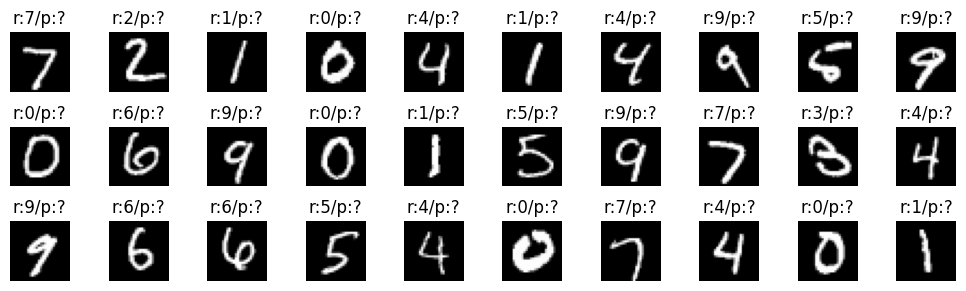

In [24]:
plt_row = 3    # 3행
plt_col = 10   #10열
# plt.figure(figsize=(plt_col, plt_row))  ##(가로,세로)
# plt.imshow(X_test[0])
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
# axarr[1,1].imshow(X_test[11], cmap='gray')
# axarr[1,1].axis('off')
# axarr[1,1].set_title(f'real:{y_test[11]}')
for i in range(plt_row*plt_col):
    ax = axarr[i//plt_col, i%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'r:{y_test[i]}/p:?')
plt.tight_layout()

# 1. DNN

In [26]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Train데이터 6만개 => Train(5만개)+val(만개)로 분리, 한번만 실행!!
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# 입력(독립) 변수 (n,28,28)  -> (n, 28*28)  ->  실수형변환  -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0  # 28*28을 -1로 입력하면 알아서 784로 해준다??
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0     # =>2차원을 1차원으로 만든것
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0
train_X.shape, val_X.shape, test_X.shape

# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])
# to_categorical(y_train)[0] 
train_Y = to_categorical(y_train, 10)  # 10은 카테고리 갯수(안쓰면 자동 입력. 가장큰수 만큼)
val_Y   = to_categorical(y_val, 10)
test_Y  = to_categorical(y_test, 10)
train_Y.shape,  val_Y.shape,   test_Y.shape
# 모델
model = Sequential()
model.add(Input(shape=(784,)))   # DNN은 1차원, 입력은 784개
model.add(Dense(units=1024, activation='relu'))        # activation='leakyrelu'-사용불가, 비율을 지정해줘야해서 바로 쓸 수 없다
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.01))  # 음수결과에 대해 1%만 통과
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',  # sparse_categorical_crossentropy 하면 알아서 해준다
              optimizer='adam',
              metrics=['accuracy'])  # 평가지표

hist = model.fit(train_X, train_Y,  # 학습셋
                 epochs=20,
                 batch_size=100,
                 validation_data=(val_X, val_Y),
                 verbose=1)

Epoch 1/20
500/500 [==============================] - 5s 9ms/step - loss: 0.3056 - accuracy: 0.9054 - val_loss: 0.1072 - val_accuracy: 0.9688
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1329 - accuracy: 0.9604 - val_loss: 0.0970 - val_accuracy: 0.9721
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1008 - accuracy: 0.9702 - val_loss: 0.0888 - val_accuracy: 0.9741
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0789 - accuracy: 0.9770 - val_loss: 0.0781 - val_accuracy: 0.9782
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0686 - accuracy: 0.9783 - val_loss: 0.0713 - val_accuracy: 0.9797
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0602 - accuracy: 0.9815 - val_loss: 0.0801 - val_accuracy: 0.9775
Epoch 7/20
500/500 [==============================] - 5s 9ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.0831 - val_accuracy: 0.9777
E

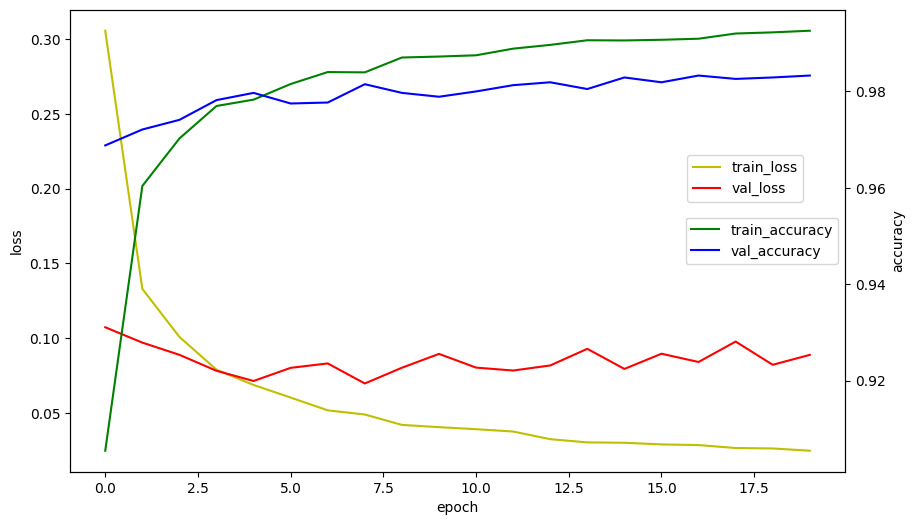

In [27]:
# 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'],'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val_loss')
acc_ax = loss_ax.twinx()  # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [28]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
acc

0.9850000143051147

In [31]:
# 틀린갯수
len(test_Y) - len(test_Y) * acc  # test_Y :실제값을 원핫인코딩한 값

149.99985694885254

In [36]:
# 틀린 이미지만 출력하기 위해, 실제값과 예측값
# 실제값들

real = test_Y.argmax(axis=1)
real = np.argmax(test_Y, axis=1)
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [37]:
np.all(test_Y.argmax(axis=1) == y_test)

True

In [39]:
# 예측값
y_hat = model.predict(test_X, verbose=0).argmax(axis=1)

In [40]:
y_test.shape, y_hat.shape  # 실제값과 예측값

((10000,), (10000,))

In [41]:
# 성능 평가표(교차표, 혼동행렬) 틀린것만 그리기전에
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,972,0,1,0,1,1,3,1,1,0
1,0,1129,2,0,0,0,2,1,1,0
2,1,0,1018,1,1,0,2,6,3,0
3,1,0,4,995,0,3,0,4,3,0
4,2,0,1,0,966,0,4,0,0,9
5,3,0,0,8,1,870,5,0,4,1
6,1,2,0,1,3,1,950,0,0,0
7,2,1,5,1,1,0,0,1014,1,3
8,2,0,2,2,0,4,2,5,954,3


In [43]:
plt_row = 20
plt_col = 10
i = 0    # y_hat과 y_test를 액세스할 index:0~9999
cnt = 0  # 이미지 출력횟수 : 1~120
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    print(title, end='\t')
    i += 1
    cnt += 1

r:3/p:8	r:9/p:8	r:4/p:2	r:6/p:0	r:8/p:0	r:8/p:2	r:1/p:8	r:2/p:6	r:2/p:7	r:5/p:3	r:7/p:3	r:5/p:8	r:4/p:9	r:8/p:9	r:5/p:4	r:1/p:6	r:5/p:3	r:6/p:5	r:4/p:6	r:4/p:0	r:7/p:2	r:9/p:4	r:4/p:9	r:9/p:5	r:5/p:8	r:8/p:3	r:7/p:9	r:5/p:6	r:5/p:3	r:9/p:7	r:7/p:0	r:8/p:7	r:4/p:6	r:9/p:3	r:9/p:8	r:0/p:6	r:3/p:7	r:2/p:8	r:3/p:7	r:9/p:4	r:9/p:3	r:8/p:3	r:1/p:7	r:7/p:9	r:4/p:9	r:3/p:7	r:6/p:1	r:5/p:6	r:9/p:6	r:5/p:8	r:9/p:1	r:6/p:4	r:4/p:9	r:2/p:4	r:5/p:3	r:9/p:0	r:6/p:1	r:5/p:3	r:9/p:4	r:8/p:0	r:3/p:2	r:3/p:2	r:9/p:5	r:3/p:5	r:8/p:5	r:9/p:7	r:1/p:2	r:5/p:9	r:7/p:9	r:2/p:6	r:4/p:9	r:4/p:9	r:9/p:1	r:6/p:4	r:5/p:0	r:8/p:5	r:5/p:8	r:4/p:6	r:7/p:8	r:2/p:3	r:0/p:4	r:5/p:6	r:1/p:2	r:9/p:3	r:4/p:6	r:7/p:1	r:0/p:2	r:9/p:3	r:9/p:0	r:2/p:7	r:9/p:7	r:2/p:8	r:2/p:7	r:5/p:3	r:3/p:2	r:8/p:7	r:9/p:1	r:2/p:7	r:8/p:7	r:3/p:5	r:9/p:4	r:8/p:2	r:9/p:4	r:4/p:9	r:8/p:6	r:7/p:4	r:3/p:7	r:7/p:0	r:4/p:9	r:5/p:3	r:3/p:8	r:3/p:8	r:3/p:0	r:3/p:5	r:9/p:3	r:9/p:3	r:9/p:3	r:8/p:9	r:9/p:7	r:0/p:7	r:8/p:7	r:0/p:5	r:8/p:9	r:1/p:6	r:8/p:7	

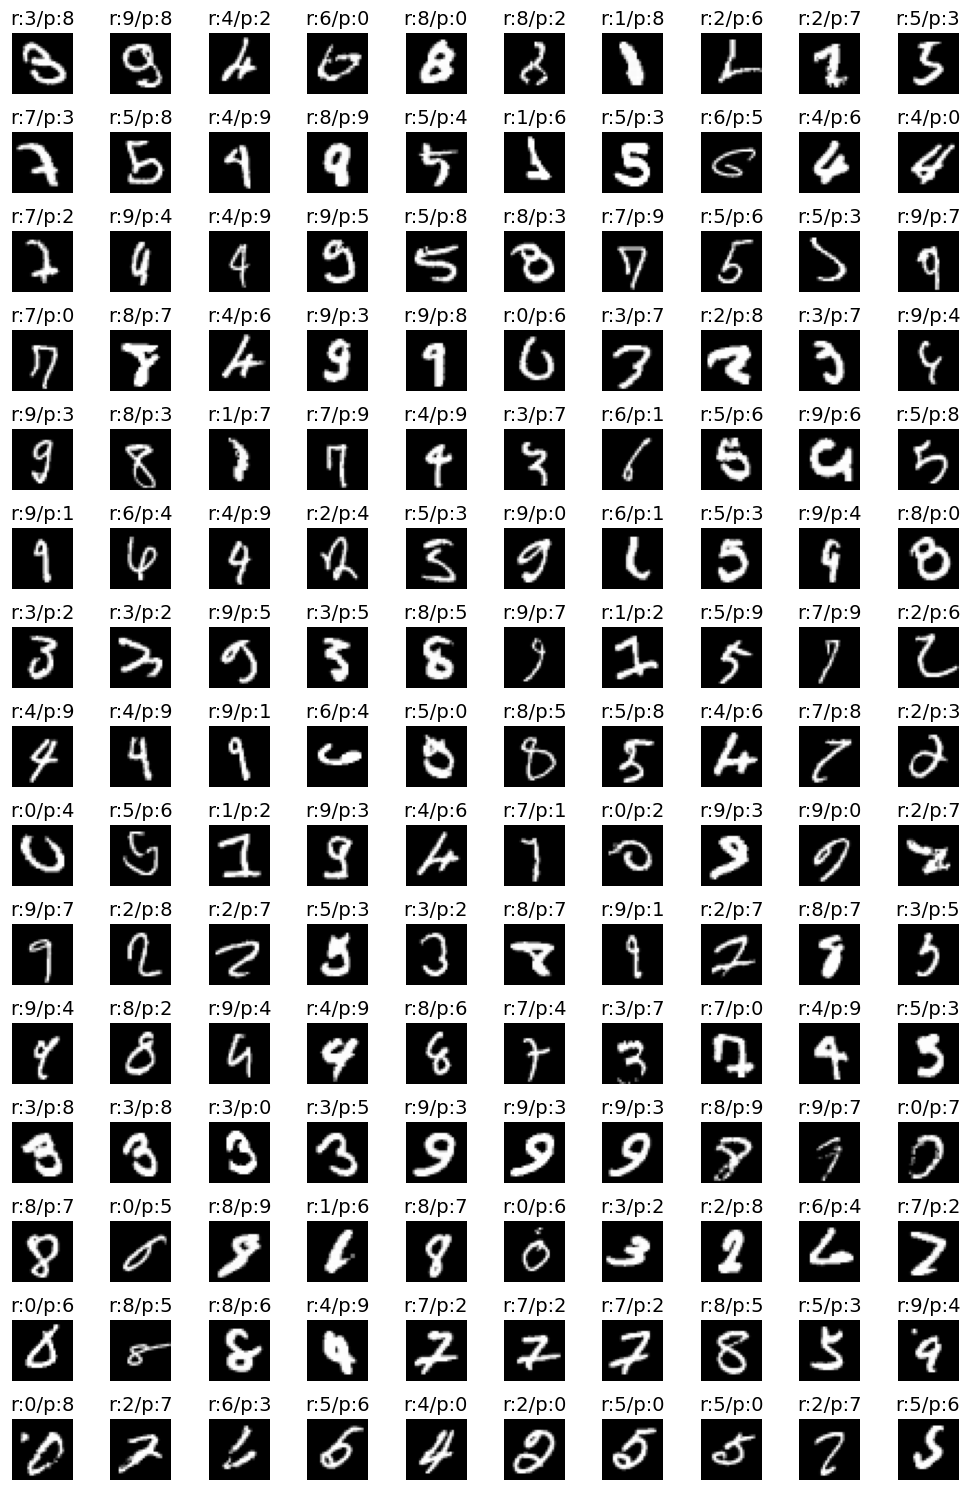

In [46]:
plt_row = 15   
plt_col = 10   
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0    # y_hat과 y_test를 액세스할 index:0~9999
cnt = 0  # 이미지 출력횟수 : 1~150
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
plt.tight_layout()

# 2. CNN
- 컨볼루션 layer -> pooling -> 컨볼루션 layer ->  pooling -> Flatten -> DNN
- Flatten : 2차원을 1차원으로

In [57]:
import numpy as np
import pandas as pd   # 무거워서 시간이 걸린다
from tensorflow.keras.datasets import mnist       # mnist훈련셋과 테스트셋(load_data)
from tensorflow.keras.utils import to_categorical # 원핫인코딩  ---- 전처리를 위한
from tensorflow.keras.models import Sequential, save_model, load_model  # 모델관련
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
# 28*28*1 -> (conv) -> 28*28*32 -> 14*14*32
width=28; height=28
model = Sequential([
        Conv2D(filters=32,     # 필터수  # 필터를 만든다  ->32개 필터가 파라미터
               kernel_size=3,  # 필터사이즈 3x3
               padding='same', # 패딩처리, zero-padding / padding='valid'가 default
               input_shape = (width, height,1),  # 1은 흑백채널
               activation='relu'
        ), # 28*28 1채널 이미지를 32개의 필터로 특성맵 추출 => 28*28*32특성맵
        MaxPool2D(pool_size=(2,2)),  # 가로2배, 세로2배 ->전체 4배 줄어듦
        Dropout(0.1),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),  
        Dropout(0.25),
        Flatten(),   # 2304
        Dense(units=128, activation='relu'),
        Dropout(0.4),
        Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 64)         

In [63]:
%%time
# 1. 데이터 생성 & 전처리(2차원 그대로 둘것) 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Train데이터 6만개 => Train(5만개)+val(만개)로 분리, 한번만 실행!!
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
train_X = X_train.astype('float32')/255.0
val_X   = X_val.astype('float32')/255.0
test_X  = X_test.astype('float32')/255.0

train_Y = to_categorical(y_train)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
train_X.shape, y_train.shape, val_X.shape, y_val.shape, test_X.shape, y_test.shape

# 2. 모델 생성
width=28; height=28
model = Sequential()
model.add(Conv2D(filters=32,    
               kernel_size=3,  
               padding='same', 
               input_shape = (width, height,1),  
               activation='relu'
        ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))    
model.add(Dropout(0.4)) 
model.add(Dense(units=10, activation='softmax')) 

# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 4. 학습하기
earlyStopping = EarlyStopping(patience=10)
checkpoint = ModelCheckpoint(
    filepath='mnist-{epoch:02d}-loss{val_loss:.4f}-val{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
hist = model.fit(train_X, train_Y, epochs=50, batch_size=32,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[earlyStopping, checkpoint])

Epoch 1/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9324
Epoch 1: val_accuracy improved from -inf to 0.98480, saving model to mnist-01-loss0.0538-val0.9848.h5
1563/1563 [==============================] - 21s 13ms/step - loss: 0.2214 - accuracy: 0.9324 - val_loss: 0.0538 - val_accuracy: 0.9848
Epoch 2/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9756
Epoch 2: val_accuracy improved from 0.98480 to 0.98930, saving model to mnist-02-loss0.0410-val0.9893.h5
1563/1563 [==============================] - 22s 14ms/step - loss: 0.0801 - accuracy: 0.9756 - val_loss: 0.0410 - val_accuracy: 0.9893
Epoch 3/50
1562/1563 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9798
Epoch 3: val_accuracy improved from 0.98930 to 0.99070, saving model to mnist-03-loss0.0345-val0.9907.h5
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0636 - accuracy: 0.9798 - val_loss: 0.0345 - val_accura

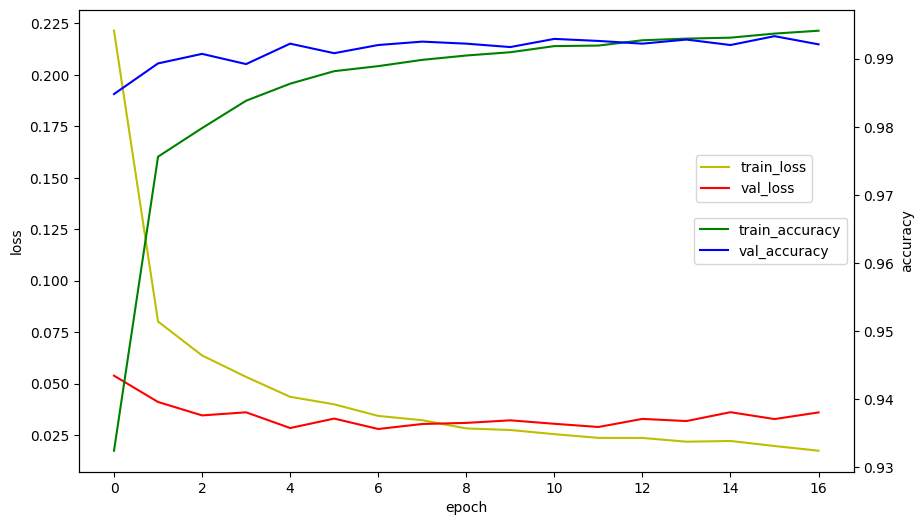

In [68]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()


In [64]:
# 모델 평가
loss, acc = model.evaluate(test_X, test_Y, verbose=0)
print('최종 모델 : ',acc, loss)

최종 모델 :  0.9929999709129333 0.031135985627770424


In [65]:
model1 = load_model('mnist-21-loss0.0362-val0.9931.h5')
loss1, acc1 = model1.evaluate(test_X, test_Y, verbose=0)
print('model1 : ',acc1, loss1)

model1 :  0.9933000206947327 0.024396875873208046


In [69]:
model2 = load_model('mnist-16-loss0.0327-val0.9933.h5')
loss2, acc2 = model2.evaluate(test_X, test_Y, verbose=0)
print('model2 : ',acc2, loss2)

model2 :  0.9933000206947327 0.02352973073720932


In [70]:
model3 = load_model('mnist-19-loss0.0368-val0.9927.h5')
loss3, acc3 = model3.evaluate(test_X, test_Y, verbose=0)
print('model3 : ',acc3, loss3)

model3 :  0.993399977684021 0.027024520561099052


In [73]:
# 성능평가(성능평가지표=겨차표, 혼동행렬, acc, recall, precission, f1)를 위해 실제값, 예측값
# y_test : 실제값
y_hat = model3.predict(test_X, verbose=0).argmax(axis=1) # 예측값

In [74]:
pd.crosstab(y_test, y_hat)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,978,0,0,0,0,0,0,1,1,0
1,0,1134,0,1,0,0,0,0,0,0
2,1,0,1025,0,0,0,0,4,2,0
3,0,0,2,1002,0,5,0,0,1,0
4,0,0,0,0,976,0,1,0,2,3
5,1,0,0,4,0,886,1,0,0,0
6,3,1,1,0,1,1,947,0,4,0
7,0,1,3,0,1,0,0,1021,1,1
8,2,0,1,0,0,1,0,0,968,2


In [79]:
print('accuracy : ', accuracy_score(y_test, y_hat))
# 다중분류의 타겟변수의 균형이 비슷하면 'macro'/ 균형이 안 잡힌 데이터면 'weighted'
print('recall : ', recall_score(y_test, y_hat, average='weighted'))
print('precision : ', precision_score(y_test, y_hat, average='weighted'))
print('f1_score : ', f1_score(y_test, y_hat, average='weighted'))

accuracy :  0.9934
recall :  0.9934
precision :  0.9934144418878256
f1_score :  0.9934008311092807


In [81]:
# 틀린 갯수
len(y_test) - len(y_test)*acc3

66.00022315979004

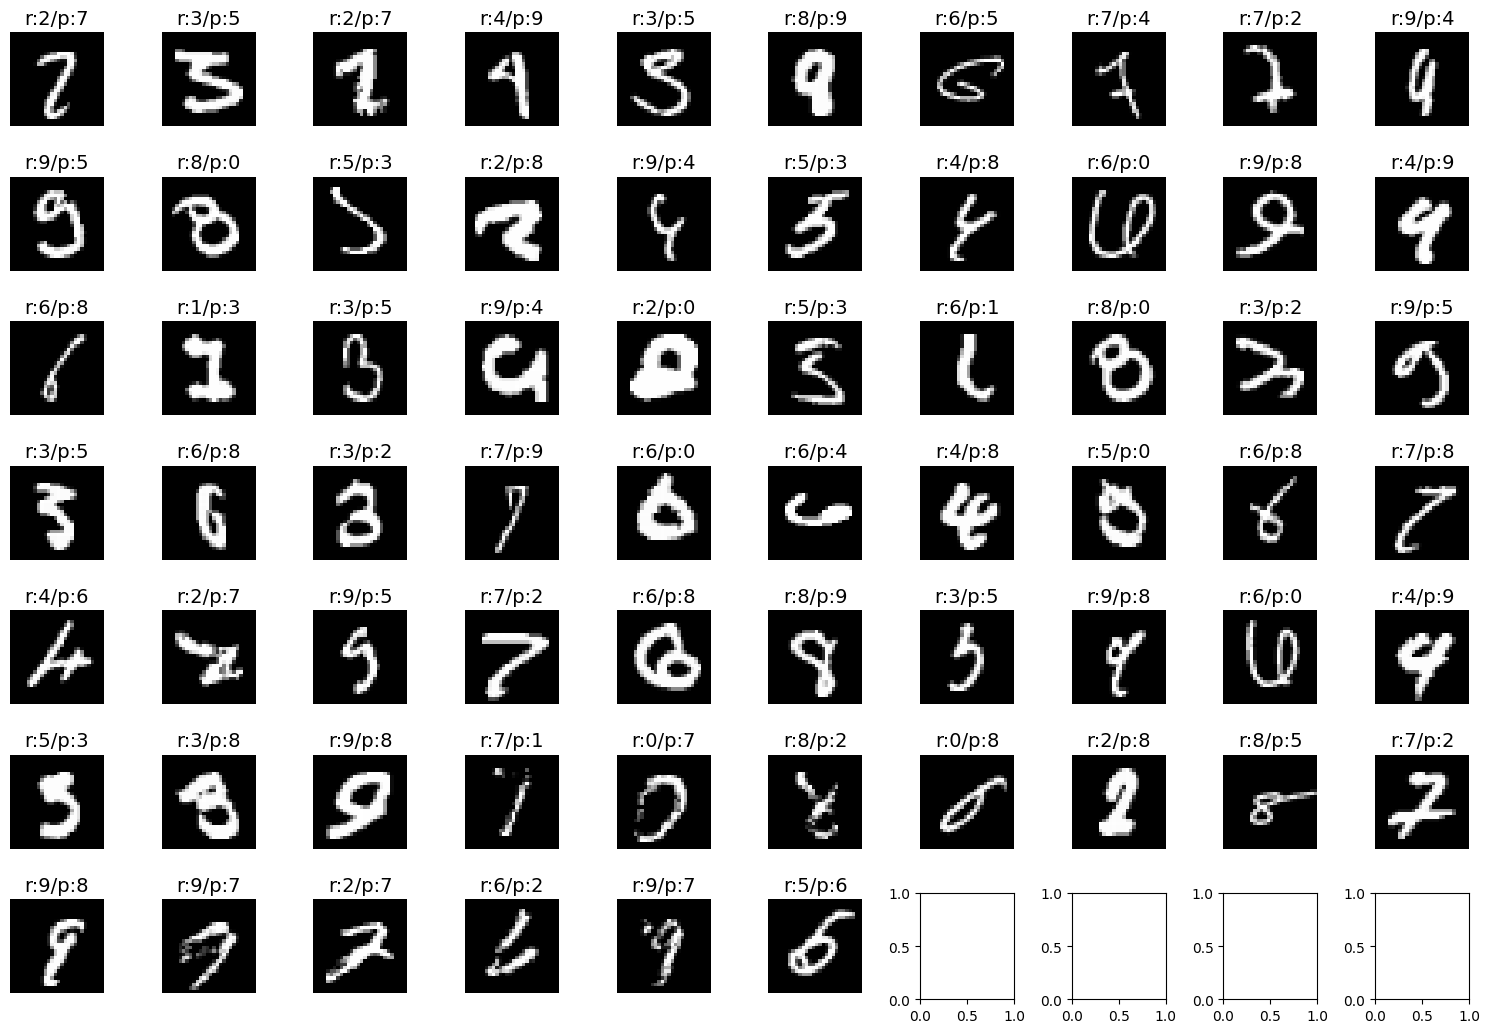

In [85]:
plt_row = 7   
plt_col = 10   
plt.rcParams['figure.figsize'] = (plt_col*1.5, plt_row*1.5)
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
i = 0    # y_hat과 y_test를 액세스할 index:0~9999
cnt = 0  # 이미지 출력횟수 : 1~150
while (cnt<plt_row*plt_col) & (i<len(y_test)):
    if(y_test[i]==y_hat[i]):
        i += 1
        continue
    title = f'r:{y_test[i]}/p:{y_hat[i]}'
    ax = axarr[cnt//plt_col, cnt%plt_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    i += 1
    cnt += 1
plt.tight_layout()